## Clone repository

In [106]:
![ -d cnn_txf_bias ] || git clone https://github.com/shikhartuli/cnn_txf_bias.git
%cd cnn_txf_bias
%ls

Cloning into 'cnn_txf_bias'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 3162 (delta 22), reused 34 (delta 12), pack-reused 3113
Receiving objects: 100% (3162/3162), 176.58 MiB | 56.12 MiB/s, done.
Resolving deltas: 100% (702/702), done.
Checking out files: 100% (6009/6009), done.
/content/cnn_txf_bias/error-consistency/raw-data_new/texture-shape_cue-conflict/cnn_txf_bias
big_transfer/     COS_454_Project_Proposal.pdf  README.md  texture-vs-shape/
CNN_vs_Human.pdf  COS_454_Project_Report.pdf    simclr/    vision_transformer/
CNN_vs_Human.png  error-consistency/            tests/


In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
import os

%cd error-consistency/raw-data_new/texture-shape_cue-conflict

/content/cnn_txf_bias/error-consistency/raw-data_new/texture-shape_cue-conflict/cnn_txf_bias/error-consistency/raw-data_new/texture-shape_cue-conflict


## Generate Human confusion matrices

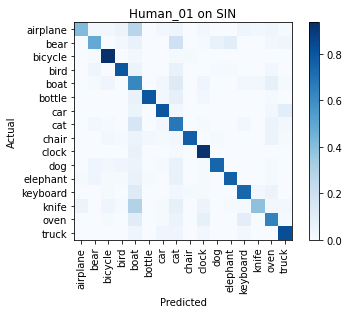

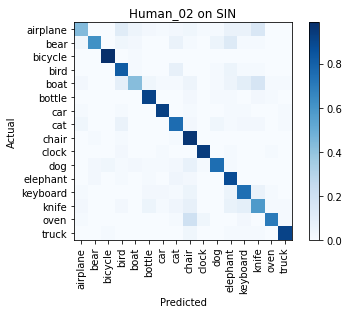

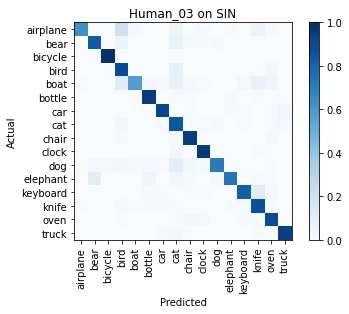

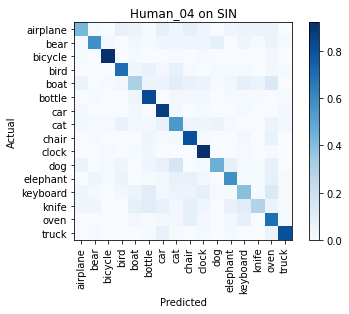

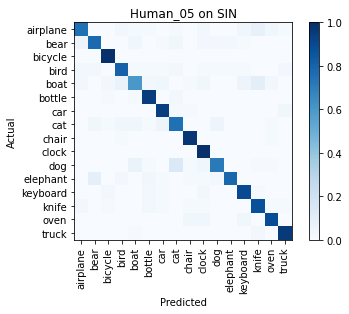

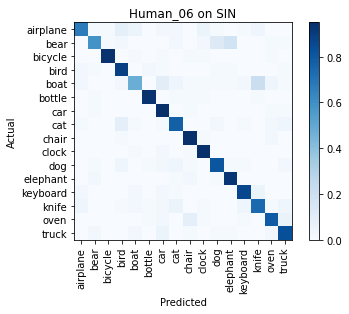

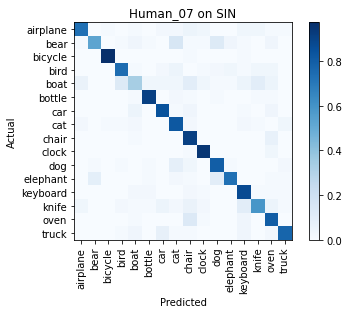

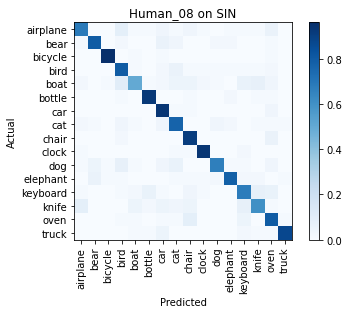

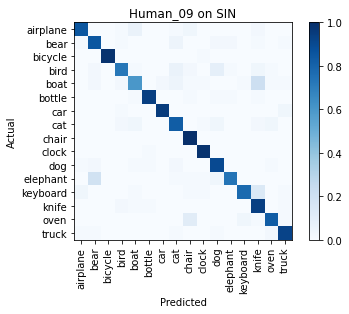

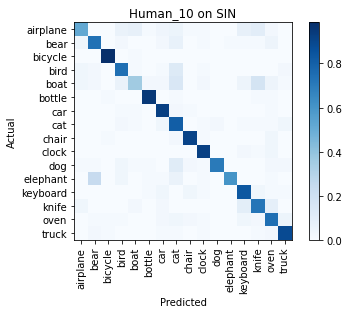

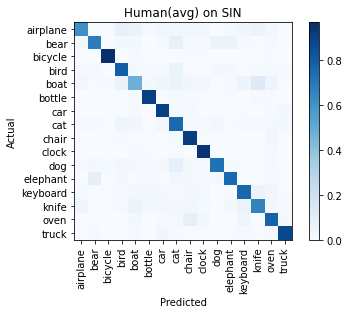

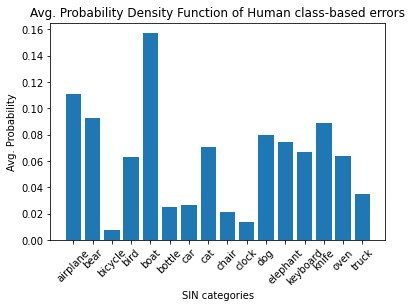

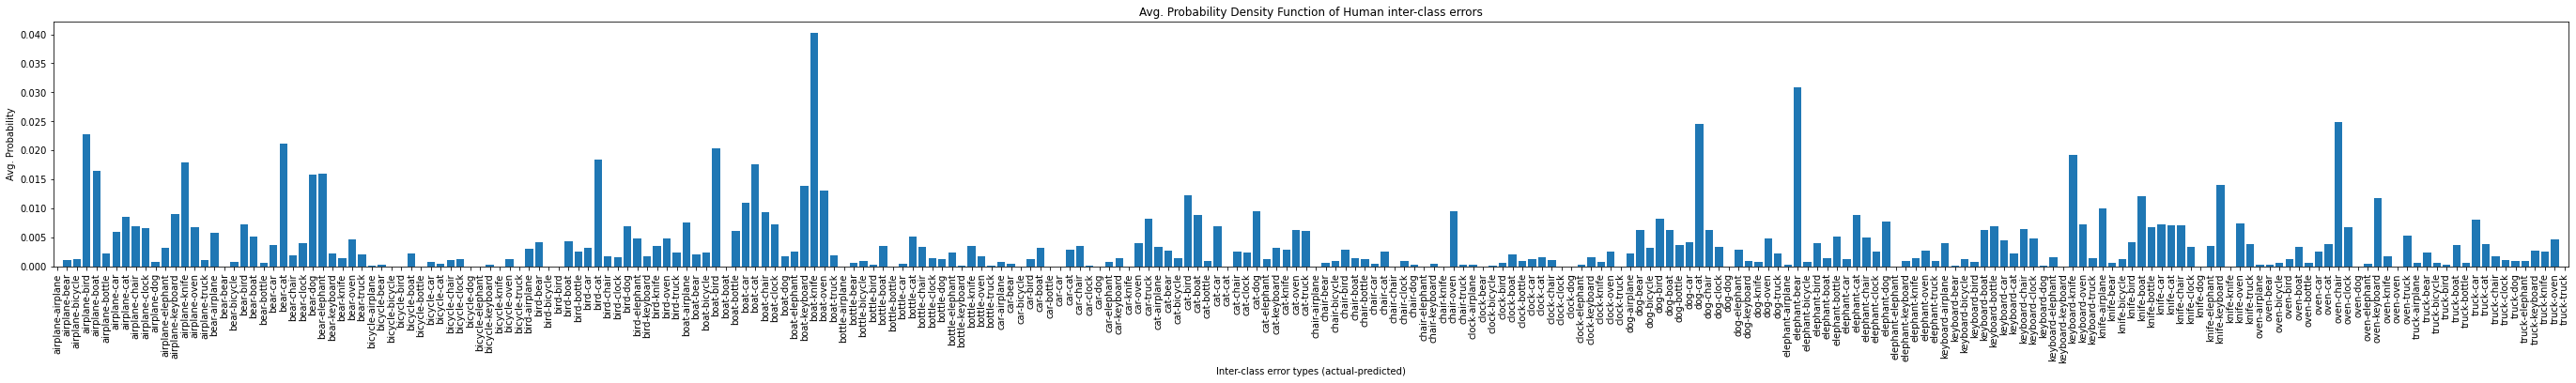

In [108]:
categories_SIN = os.listdir('../../../texture-vs-shape/stimuli/style-transfer-preprocessed-512/')
categories_SIN.sort()

class_pdf_list = []
inter_pdf_list = []
misclassification_human = {}
cm_norm_list = []
cm_norm_dict = {}

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = 0

for sub in range(1, 11):
  str_sub = '0'+str(sub) if sub < 10 else str(sub)
  human_csv = pd.read_csv(f'./texture-shape_cue-conflict_subject-{str_sub}_session_1.csv')
  pred = human_csv['object_response']
  true = human_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_list.append(cm_norm)

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  for i in range(len(categories_SIN)):
    misclassification_human[categories_SIN[i]] += cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  class_pdf_list.append(class_pdf_errors)
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)
  inter_pdf_list.append(inter_pdf_errors)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues')
  plt.title(f'Human_{str_sub} on SIN')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

class_pdf_avg = np.zeros_like(class_pdf_errors)
inter_pdf_avg = np.zeros_like(inter_pdf_errors)
cm_norm_avg = np.zeros_like(cm_norm)
for i in range(10):
  class_pdf_avg += class_pdf_list[i]
  cm_norm_avg += cm_norm_list[i]
class_pdf_avg = np.divide(class_pdf_avg, 10)
cm_norm_avg = np.divide(cm_norm_avg, 10)

for i in range(10):
  inter_pdf_avg += inter_pdf_list[i]
inter_pdf_avg = np.divide(inter_pdf_avg, 10)

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = np.divide(misclassification_human[categories_SIN[i]], 10)

human_class_pdf = class_pdf_avg
human_inter_pdf = inter_pdf_avg

cm_norm_dict['Human_avg'] = cm_norm_avg

fig, ax = plt.subplots()
plt.imshow(cm_norm_avg, cmap = 'Blues')
plt.title(f'Human(avg) on SIN')
plt.colorbar()
ax.set_xticks(np.arange(16))
ax.set_yticks(np.arange(16))
ax.set_xticklabels(categories_SIN, rotation=90)
ax.set_yticklabels(categories_SIN)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

fig = plt.figure()
plt.bar(categories_SIN, class_pdf_avg)
plt.xticks(rotation = 45)
plt.xlabel('SIN categories')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human class-based errors')
plt.show()

fig = plt.figure(figsize=[48, 4.8])
plt.bar([str(c1+'-'+c2) for c1, c2 in itertools.product(categories_SIN, categories_SIN)], inter_pdf_avg)
plt.xticks(rotation = 90)
plt.xlabel('Inter-class error types (actual-predicted)')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human inter-class errors')
plt.margins(x=0,tight=True)
plt.show()

## Define distance metric

In [109]:
def kl_distance(p, q):
  non_zero_indices = np.intersect1d(np.where(p!=0)[0], np.where(q!=0)[0])
  return np.sum([p[i] * np.log(p[i] / q[i]) for i in non_zero_indices])

def cross_entropy(p, q):
	return -np.sum(np.where(p != 0, p * np.log(q), 0))
 
def mse(p, q):
  return np.square(np.subtract(p,q)).mean() 

## Generate ViT confusion matrices

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


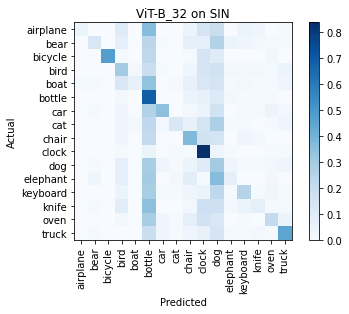

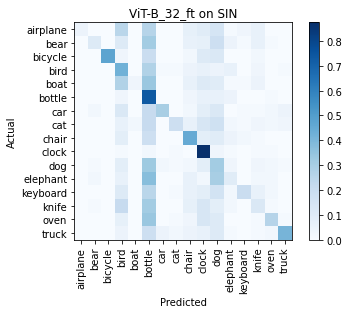

In [110]:
# vit_models = ['B_32', 'B_16', 'L_32', 'L_16', 'B_32_ft']
vit_models = ['B_32', 'B_32_ft']

kl_dist_class = {}
ce_dist_class = {}
kl_dist_inter = {}
ce_dist_inter = {}
mse_misclassification = {}
acc_SIN = {}

for model in vit_models:
  vit_csv = pd.read_csv(f'./texture-shape_cue-conflict_ViT-{model}_session-1.csv')
  pred = vit_csv['object_response']
  true = vit_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  if model == 'B_32': cm_norm_dict[f'ViT-{model}'] = cm_norm
  if model == 'B_32_ft': cm_norm_dict[f'ViT-{model}'] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[f'ViT-{model}'] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  kl_dist_class[f'ViT-{model}'] = kl_distance(class_pdf_errors, human_class_pdf)
  ce_dist_class[f'ViT-{model}'] = cross_entropy(class_pdf_errors, human_class_pdf)
  kl_dist_inter[f'ViT-{model}'] = kl_distance(inter_pdf_errors, human_inter_pdf)
  ce_dist_inter[f'ViT-{model}'] = cross_entropy(inter_pdf_errors, human_inter_pdf)
  acc_SIN[f'ViT-{model}'] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues')
  plt.title(f'ViT-{model} on SIN')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

## Generate ResNet confusion matrices

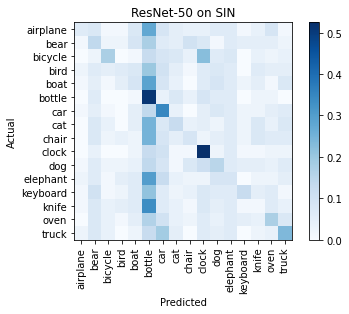

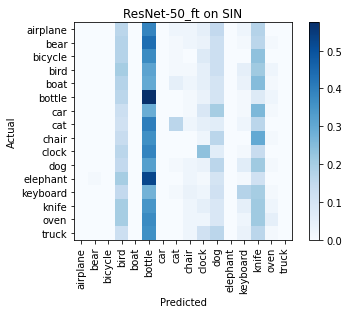

In [111]:
resnet_models = ['resnet50', 'resnet50_ft']

for model in resnet_models:
  resnet_csv = pd.read_csv(f'./texture-shape_cue-conflict_{model}_session-1.csv')
  pred = resnet_csv['object_response']
  true = resnet_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  if model == 'resnet50': cm_norm_dict[f'ResNet-50{model[8:]}'] = cm_norm
  if model == 'resnet50_ft': cm_norm_dict[f'ResNet-50{model[8:]}'] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[f'ResNet-50{model[8:]}'] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  kl_dist_class[f'ResNet-50{model[8:]}'] = kl_distance(class_pdf_errors, human_class_pdf)
  ce_dist_class[f'ResNet-50{model[8:]}'] = cross_entropy(class_pdf_errors, human_class_pdf)
  kl_dist_inter[f'ResNet-50{model[8:]}'] = kl_distance(inter_pdf_errors, human_inter_pdf)
  # ce_dist_inter[f'ResNet-50{model[8:]}'] = cross_entropy(inter_pdf_errors, human_inter_pdf)
  acc_SIN[f'ResNet-50{model[8:]}'] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues')
  plt.title(f'ResNet-50{model[8:]} on SIN')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

## Plot relevant confusion matrices together

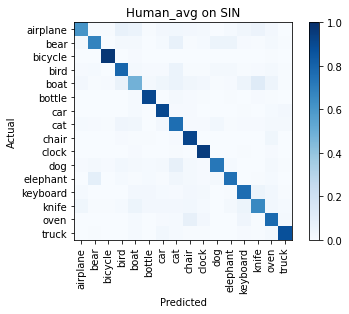

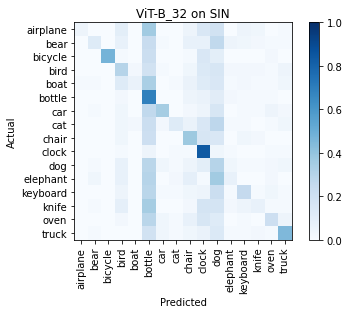

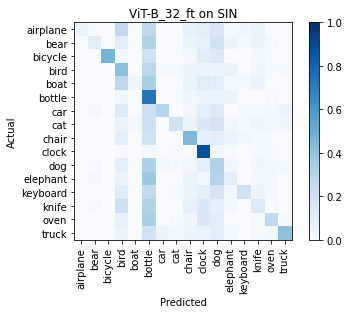

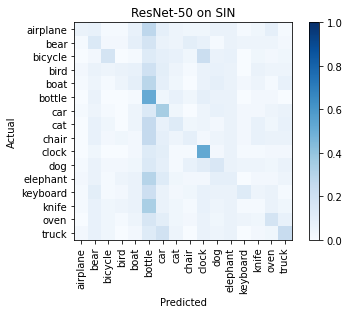

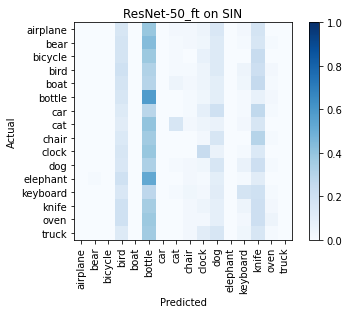

In [112]:
for model in cm_norm_dict.keys():
  
  fig, ax = plt.subplots()
  plt.imshow(cm_norm_dict[model], cmap = 'Blues', vmax = 1)
  plt.title(f'{model} on SIN')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

## Plot KL distance for class-wise errors

Model: ViT-B_32, 	 KL-Distance: 0.108
Model: ViT-B_32_ft, 	 KL-Distance: 0.109
Model: ResNet-50, 	 KL-Distance: 0.185
Model: ResNet-50_ft, 	 KL-Distance: 0.251


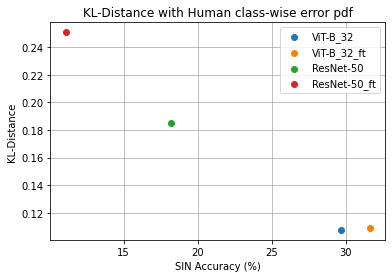

In [113]:
for model in kl_dist_class.keys():
  plt.scatter(acc_SIN[model]*100, kl_dist_class[model], label = model)
  print(f'Model: {model}, \t KL-Distance: {kl_dist_class[model]:0.3f}')

plt.grid()
plt.xlabel('SIN Accuracy (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human class-wise error pdf')
plt.legend()
plt.show()

## Plot KL distance for inter-class errors

Model: ViT-B_32, 	 KL-Distance: 1.170
Model: ViT-B_32_ft, 	 KL-Distance: 1.211
Model: ResNet-50, 	 KL-Distance: 0.789
Model: ResNet-50_ft, 	 KL-Distance: 1.383


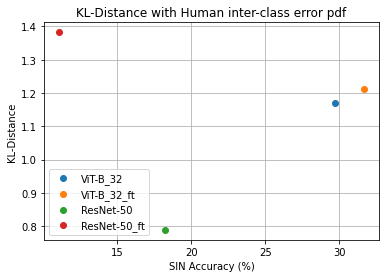

In [114]:
for model in kl_dist_inter.keys():
  plt.scatter(acc_SIN[model]*100, kl_dist_inter[model], label = model)
  print(f'Model: {model}, \t KL-Distance: {kl_dist_inter[model]:0.3f}')

plt.grid()
plt.xlabel('SIN Accuracy (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human inter-class error pdf')
plt.legend()
plt.show()

## Plot cross-entropy of class-wise errors

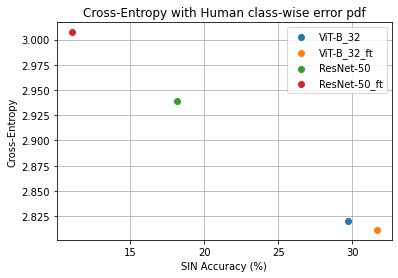

In [115]:
for model in ce_dist.keys():
  plt.scatter(acc_SIN[model]*100, ce_dist[model], label = model)

plt.grid()
plt.xlabel('SIN Accuracy (%)')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy with Human class-wise error pdf')
plt.legend()
plt.show()

## Plot MSE distance between misclassifications per class

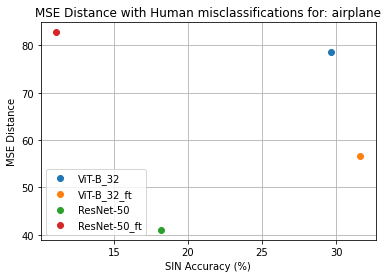

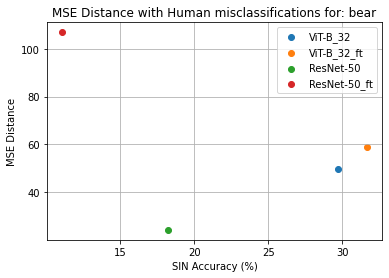

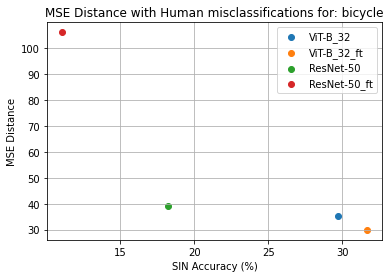

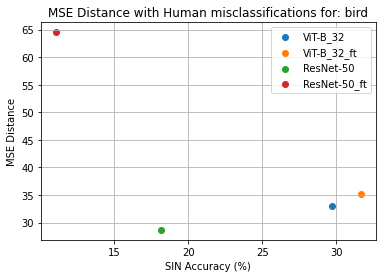

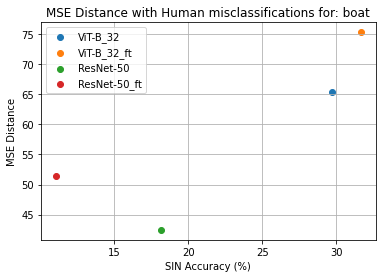

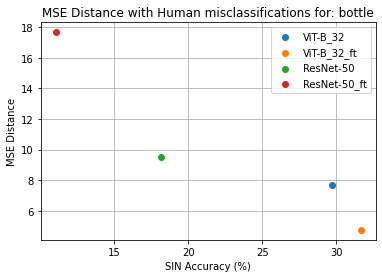

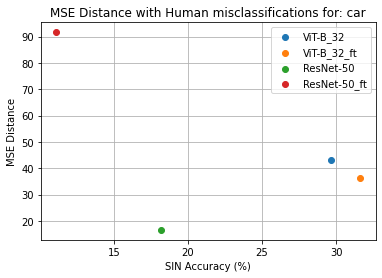

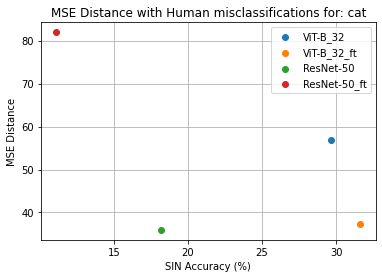

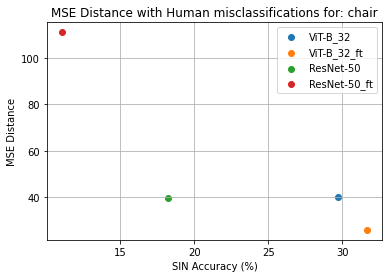

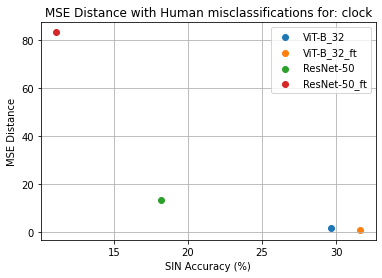

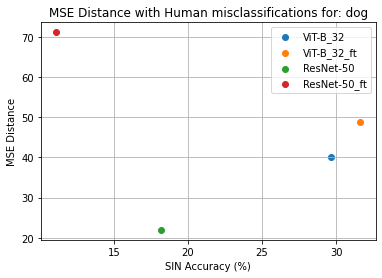

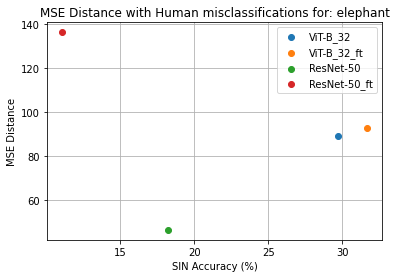

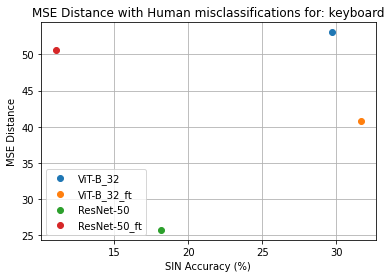

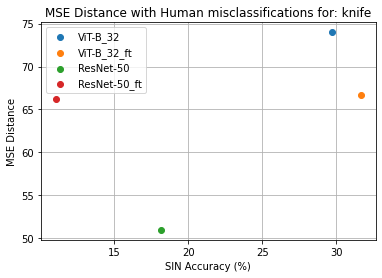

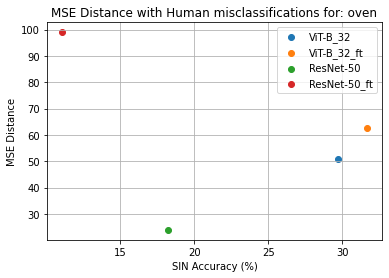

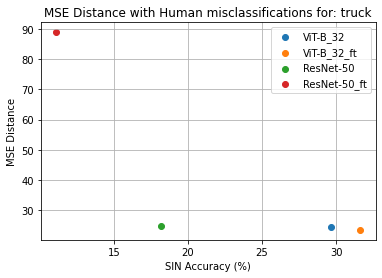

In [116]:
for category in categories_SIN:
  for model in mse_misclassification.keys():
    plt.scatter(acc_SIN[model]*100, mse_misclassification[model][category], label = model)
  
  plt.grid()
  plt.xlabel('SIN Accuracy (%)')
  plt.ylabel('MSE Distance')
  plt.title(f'MSE Distance with Human misclassifications for: {category}')
  plt.legend()
  plt.show()

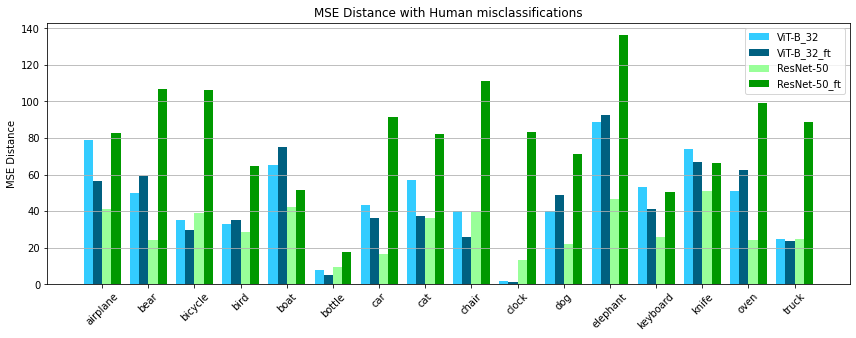

In [137]:
x = np.arange(len(categories_SIN))
width = 0.2

fig, ax = plt.subplots(figsize=[12, 4.8])

colors = ['#33ccff', '#006080', '#99ff99', '#009900']

count = 0
for model in mse_misclassification.keys():
  rects = ax.bar(x - 3*width/2 + width*count, [mse_misclassification[model][cat] for cat in categories_SIN], width, label=model, color=colors[count])
  count += 1

ax.set_ylabel('MSE Distance')
ax.set_title('MSE Distance with Human misclassifications')
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.set_xticklabels(categories_SIN)
ax.legend()
fig.tight_layout()
plt.grid(axis = 'y')
plt.show()